In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")


In [249]:
df['Diabetes'] = df['Diabetes'].replace(2, 1)

# construct Y column
df['Y'] = df['HeartDiseaseorAttack'].astype(int).astype(str) + ',' + df['Diabetes'].astype(int).astype(str) + ',' + df['Stroke'].astype(int).astype(str)

In [250]:
print("Dimensions of the dataset : ", df.shape)
df['Y'].value_counts()

Dimensions of the dataset :  (253680, 23)


Y
0,0,0    193793
0,1,0     29639
1,0,0     13151
1,1,0      6805
0,0,1      4559
1,0,1      2200
0,1,1      1796
1,1,1      1737
Name: count, dtype: int64

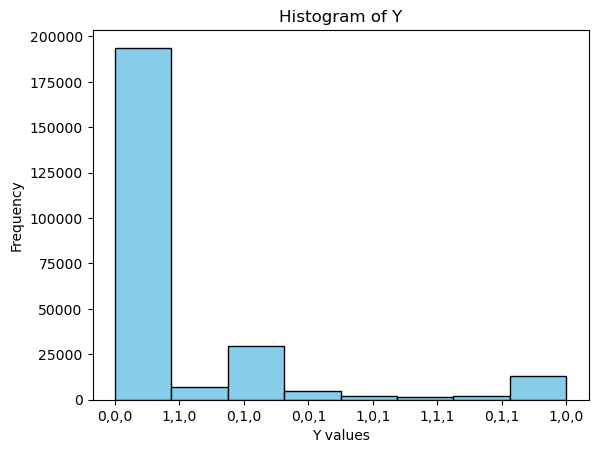

In [251]:
plt.hist(df['Y'], bins=8, color='skyblue', edgecolor='black')
plt.title('Histogram of Y')
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.show()

In [252]:
df['Age'].unique()

array([ 9.,  7., 11., 10.,  8., 13.,  4.,  6.,  2., 12.,  5.,  1.,  3.])

In [253]:
def create_age_groups(age):
    if age in [1, 2, 3]:
        return 'Group1(1-3)'
    elif age in [4, 5, 6]:
        return 'Group2(4-6)'
    elif age in [7, 8, 9]:
        return 'Group3(7-9)'
    elif age in [10, 11]:
        return 'Group4(10-11)'
    elif age in [12, 13]:
        return 'Group5(12-13)'
    else:
        print('Unknown value')


df['Age_5Groups'] = df['Age'].apply(create_age_groups)
# columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke']
# df = df.drop(columns=columns_to_drop)


In [254]:
df['Age_5Groups'].value_counts()

Age_5Groups
Group3(7-9)      90390
Group4(10-11)    55727
Group2(4-6)      49799
Group5(12-13)    33343
Group1(1-3)      24421
Name: count, dtype: int64

In [255]:
def one_hist(column_name):
    group_counts = df[column_name].value_counts()

    # index gives the name of the class
    labels, counts = zip(*sorted(zip(group_counts.index, group_counts)))

    plt.hist(df[column_name], bins=np.arange(len(labels)+1)-0.5, color='skyblue', edgecolor='black')

    plt.xticks(range(len(labels)), labels, rotation=45)

    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.show()


In [256]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y']
feature_names = df.drop(columns=columns_to_drop).columns

# for columnName in feature_names:
#     one_hist(columnName)

# Test

# Test end

In [280]:
def stacked_hist(df, x_var, stack_var, drop_Y000=False):
    # calculate the data for the stack histogram
    df_copy = df.copy()
    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']
        
    stacked_data = df_copy.groupby([x_var, stack_var]).size().unstack()
    
    num_stacks = stacked_data.shape[1]
    colors = plt.cm.tab10.colors[:num_stacks]
    stacked_data.plot(kind='bar', stacked=True, color=colors, edgecolor='black')
    
    plt.xlabel(x_var)
    plt.ylabel('Frequency')
    plt.title('Stacked Histogram of ' + x_var + ' by ' + stack_var)
    plt.xticks(rotation=45)
    plt.show()



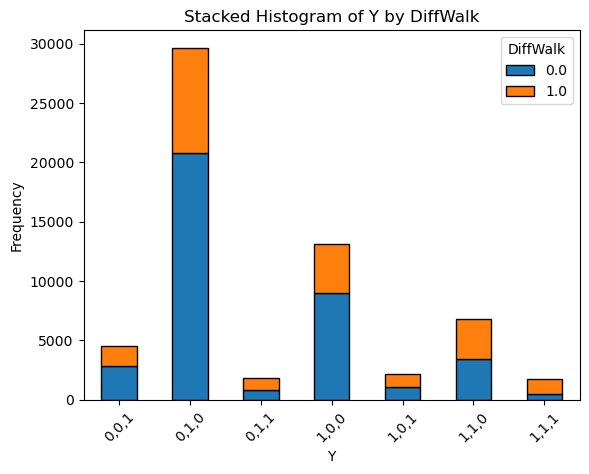

In [281]:
stacked_hist(df, 'Y', 'DiffWalk', drop_Y000=True)

In [259]:
# columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y']
# feature_names = df.drop(columns=columns_to_drop).columns
# for name in feature_names:
#     stacked_hist(df, name, 'Age_5Groups')

# Contingency Table

In [260]:
def con_table(columnName, prob=False):
    contingency_table = pd.crosstab(df[columnName], df['Y'])
    print("Contingency Table:")
    print(contingency_table)

    if prob:
        probability_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        print("\nProbability Table:")
        print(probability_table)

       

In [261]:
con_table('Sex',True)


Contingency Table:
Y     0,0,0  0,0,1  0,1,0  0,1,1  1,0,0  1,0,1  1,1,0  1,1,1
Sex                                                         
0.0  111685   2724  16329   1031   5470   1080   2804    851
1.0   82108   1835  13310    765   7681   1120   4001    886

Probability Table:
Y       0,0,0     0,0,1     0,1,0     0,1,1     1,0,0     1,0,1     1,1,0  \
Sex                                                                         
0.0  0.786658  0.019187  0.115014  0.007262  0.038528  0.007607  0.019750   
1.0  0.735037  0.016427  0.119152  0.006848  0.068761  0.010026  0.035817   

Y       1,1,1  
Sex            
0.0  0.005994  
1.0  0.007932  


In [289]:
def get_mutual_entropy(columnName, drop_Y000=False, merge_Ynot000=False):
    df_copy = df.copy()

    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']

    if merge_Ynot000:
        df_copy.loc[df_copy['Y'] != '0,0,0', 'Y'] = '1,1,1'

    contingency_table = pd.crosstab(df_copy[columnName], df_copy['Y'])
    total = contingency_table.values.sum()
    probs = contingency_table.values / total
    conditional_entropy = entropy(probs[0]) * contingency_table.iloc[0].sum() / total + entropy(probs[1]) * (contingency_table.iloc[1].sum() / total)

    prob_Y = contingency_table.sum(axis=0) / total
    entropy_Y = entropy(prob_Y)

    mutual_entropy = entropy_Y - conditional_entropy
    return mutual_entropy

In [292]:
a = get_mutual_entropy('DiffWalk', False, False)
a

0.03979444396651477

In [262]:
print(df.columns)

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Y', 'Age_5Groups'],
      dtype='object')


In [263]:
contingency_table = pd.crosstab(df['Sex'], df['Y'])
print("Contingency Table:")
contingency_table

Contingency Table:


Y,"0,0,0","0,0,1","0,1,0","0,1,1","1,0,0","1,0,1","1,1,0","1,1,1"
Sex,,,,,,,,
0.0,111685,2724,16329,1031,5470,1080,2804,851
1.0,82108,1835,13310,765,7681,1120,4001,886


In [273]:
prob_Y = contingency_table.sum(axis=0) / total_samples
entropy(prob_Y)

0.889623575276084

In [264]:
total_samples = contingency_table.values.sum()
probs = contingency_table.values / total_samples

# 计算熵值
entropyss = -np.sum(probs[1] * np.log2(probs[1] + 1e-10)) 

print("Entropy:", entropy)

Entropy: <function entropy at 0x17576a480>


In [270]:
entropy(probs[0]) * (contingency_table.iloc[0].sum() / (contingency_table.iloc[0].sum() + contingency_table.iloc[1].sum())) + entropy(probs[1]) * (contingency_table.iloc[1].sum() / (contingency_table.iloc[0].sum() + contingency_table.iloc[1].sum())) 

0.8856414904786564

In [242]:
probs[1] * np.log2(probs[1])

array([-0.52674155, -0.0514382 , -0.22311498, -0.02525071, -0.15277135,
       -0.03454025, -0.0944182 , -0.02850472])

In [243]:
0.32366761 * np.log2(0.32366761)


-0.5267415543429323

In [268]:
(contingency_table.iloc[0].sum() + contingency_table.iloc[1].sum())
total_samples

253680